## Clustering

Clustering is the most well-known unsupervised learning technique. The goal of clustering is to discover groups in observations. The groups are called clusters. 

The data points in the same cluster are similar to each other, compared to points in different clusters, which are relatively dissimilar.

There are many clustering algorithms. In this notebook, we will focus on two of them:

1. One that requires the **number of clusters** ($k$) to be specified: **K-means**. 

2. And another that does _NOT_ require the **number of clusters** to be specified: **DBSCAN**.

To compare the performance of the clustering algorithms, in the code below we will use the same six datasets capturing a wide variety of patterns and structures. 

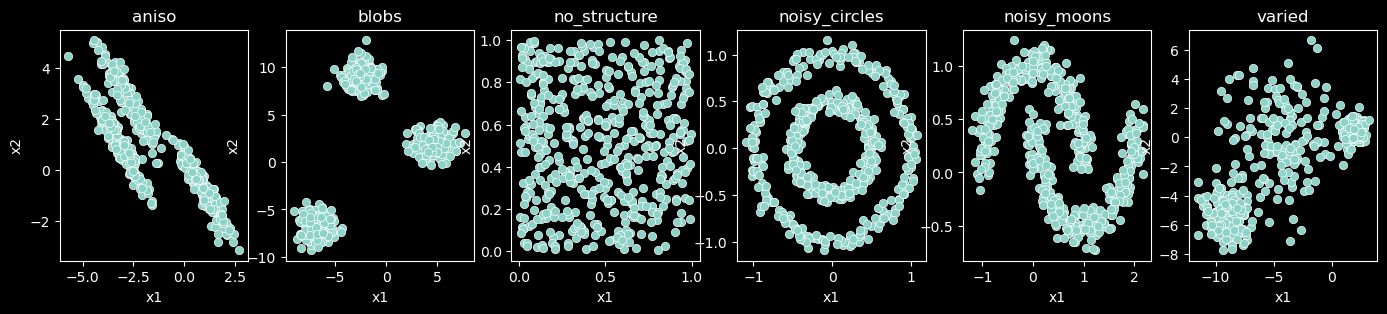

In [105]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 

plt.style.use('dark_background')

url = "https://raw.githubusercontent.com/fahadsultan/datascience_ml/main/data/clusters/"

fnames = ["aniso", "blobs", "no_structure", "noisy_circles", "noisy_moons", "varied"]

datasets = {}

fig, axs = plt.subplots(1, len(fnames), figsize=(17, 3))
for i, fname in enumerate(fnames):
    df = pd.read_csv(url + fname + ".csv", index_col=0)
    df.columns = ['x1', 'x2']
    ax = sns.scatterplot(data=df, x='x1', y='x2', ax=axs[i]);
    ax.set(title=fname)
    datasets[fname] = df

Note that the data sets are **not labeled**. Also note that unsupervised learning algorithms do not work only with 2-dimensional data but with data of any dimensionality. Here we use 2-dimensional data only to be able to visualize the results.

### K-means

The k-means algorithm is a simple and popular clustering algorithm. It is an iterative algorithm that partitions the data points into a pre-specified $k$ number of clusters. 

The algorithm works as follows: 

1. **Start**: Select $k$ random points as the initial centroids.

2. **Update Cluster Assignments**: Assign each data point to the cluster with the nearest centroid.

3. **Update Cluster Centers**: Update the centroids of the clusters by taking the average of the data points in each cluster.

4. Repeat steps 2 and 3 until the centroids do not change.

The animation below visualizes the algorithm: 

<center><img width="50%" src="https://miro.medium.com/v2/resize:fit:960/1*h2WdqGZD6WsNcUdwZDqsFA.gif" style="filter: invert(100%)" /></center>

The algorithm is guaranteed to converge to a result. However, the result may not be the optimal one. 

Because of random initialization, the algorithm converges to different results on different runs. Such algorithms or processes, where there is an element of randomness but with some bounds of predictability, are called **stochastic** algorithms or processes.

Let's try the k-means algorithm on the blobs dataset first. Note that the raw data has just two features (`x1` and `x2`) but no labels. 

In [106]:
X = datasets['blobs']
X.head()

,x1,x2
0,-5.730354,-7.583286
1,1.942992,1.918875
2,6.829682,1.164871
3,-2.901306,7.550771
4,5.841093,1.565094


The code below plots the raw data as a scatter plot.

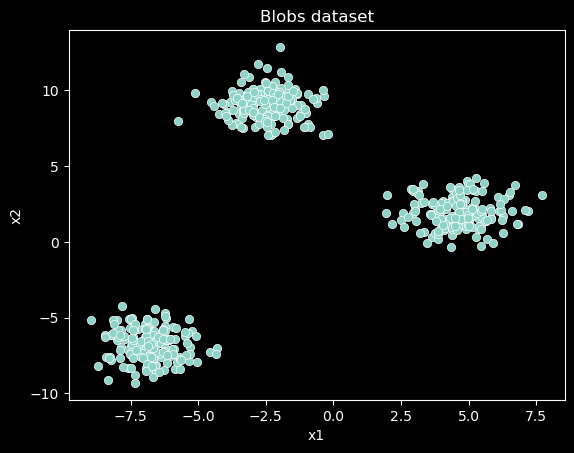

In [107]:
sns.scatterplot(data=X, x='x1', y='x2');
plt.title("Blobs dataset");

Note that there are clearly three clusters in the data where the points within each cluster are closer to each other compared to points across clusters.

We will use the `KMeans` class from the `sklearn.cluster` module.

The constructor of the `KMeans` class takes the number of clusters $k$ as input.

The `KMeans` class has a `fit()` method that takes the data as input and runs the k-means algorithm on it. 

After we fit the model to the data, we can use the `.labels_` attribute to get the discovered labels of the clusters assigned to each data point.

Below we add a third feature `label` to the data, which is the cluster label assigned to each data point by the k-means algorithm.

In [108]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

X['cluster'] = kmeans.labels_

X.head()

,x1,x2,cluster
0,-5.730354,-7.583286,1
1,1.942992,1.918875,2
2,6.829682,1.164871,2
3,-2.901306,7.550771,0
4,5.841093,1.565094,2


The code below plots the data again, but this time with the cluster labels.

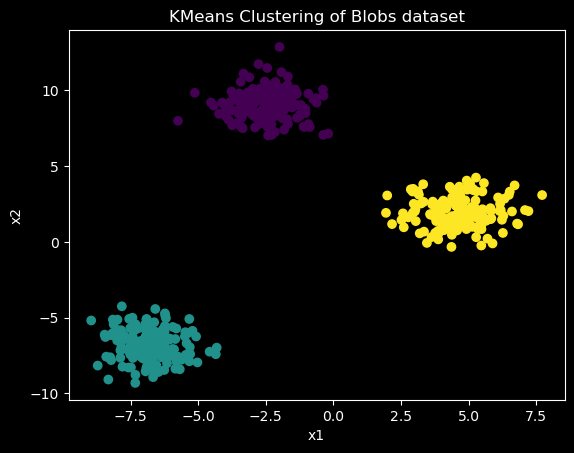

In [109]:
plt.scatter(X['x1'], X['x2'], c=X['cluster'], cmap='viridis');

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('KMeans Clustering of Blobs dataset');

Note that the k-means algorithm has perfectly discovered the three blobs in the data.

#### Implementation

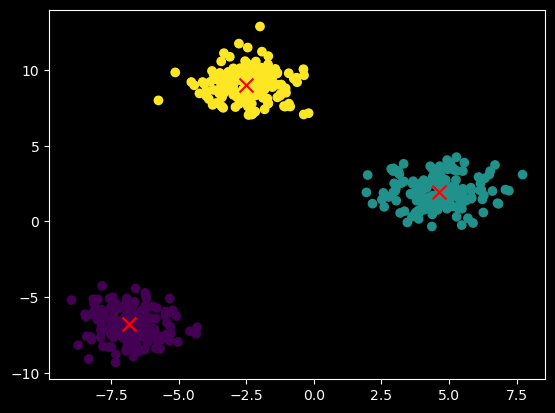

In [110]:
import pandas as pd
import numpy as np

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def initialize_centroids(df, k):
    """Randomly initialize centroids by selecting k rows from the DataFrame."""
    return df.sample(n=k, random_state=0).reset_index(drop=True)

def assign_clusters(df, centroids):
    """Assign each data point to the nearest centroid."""

    distances = pd.DataFrame(
        {i: ((df - centroids.iloc[i]) ** 2).sum(axis=1) ** 0.5 for i in centroids.index}
    )
    return distances.idxmin(axis=1)

def update_centroids(df, clusters, k):
    """Update centroids as the mean of all points in each cluster."""
    new_centroids = df.groupby(clusters).mean()
    return new_centroids.reindex(range(k)).reset_index(drop=True)

def kmeans(df, k, max_iters=1000, tolerance=1e-4):
    """K-Means clustering algorithm."""
    # Step 1: Initialize centroids
    centroids = initialize_centroids(df, k)
    for iteration in range(max_iters):
        # Step 2: Assign clusters
        clusters = assign_clusters(df, centroids)
        
        # Step 3: Update centroids
        new_centroids = update_centroids(df, clusters, k)
        
        # Step 4: Check for convergence
        if ((centroids - new_centroids).abs().sum().sum() < tolerance):
            break
        
        centroids = new_centroids

    return clusters, centroids

X = datasets['blobs']
clusters, centroids = kmeans(X[['x1', 'x2']], k=3)
X['cluster'] = clusters

plt.scatter(X['x1'], X['x2'], c=X['cluster'], cmap='viridis');
plt.scatter(centroids['x1'], centroids['x2'], c='red', marker='x', s=100);

#### Limitations of K-means

K-means is a simple and popular clustering algorithm. However, it has some limitations: 

1. It requires the number of clusters $k$ to be specified. If the number of clusters is not known in advance, then we need to try different values of $k$ and select the one that gives the best results.

2. It is sensitive to the initial random selection of centroids. The algorithm may converge to different results on different runs.

3. Since k-means is reliant on averages, it is sensitive to outliers. Outliers can significantly affect the location of the centroids and hence the clusters.

4. **Most importantly**, k-means does not work well with clusters of different sizes and densities. **It assumes that the clusters are spherical and of similar size**.

To illustrate this limitation, let's try the k-means algorithm on a dataset that does not satisfy the assumptions of the algorithm.

         x1        x2
0 -0.469276  0.210118
1 -0.164164  0.986075
2 -0.471454  0.019974
3 -0.670347 -0.657977
4 -0.826468  0.594071


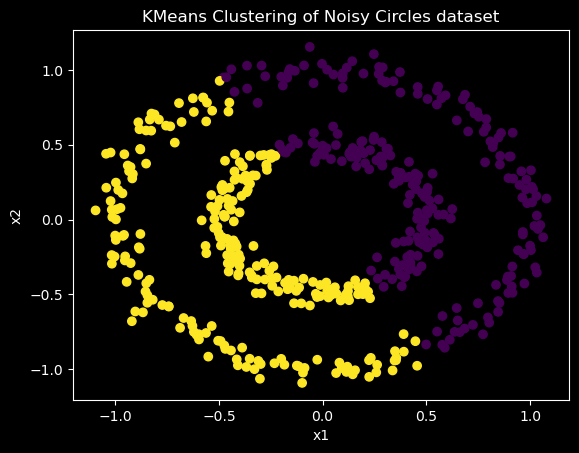

In [111]:
# Before clustering
X = datasets['noisy_circles']
print(X.head())

# Applying KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X)
X['cluster'] = kmeans.labels_

# After clustering
plt.scatter(X['x1'], X['x2'], c=X['cluster'], cmap='viridis');
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('KMeans Clustering of Noisy Circles dataset');

Note how the k-means algorithm fails to discover the two clusters in the data. This is because the clusters are a) not spherical and b) of different sizes.

Such failures of a clustering algorithm can only be detected by either visualizing the results or computing internal cluster validation metrics such as the silhouette score. 


### DBSCAN

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It is a density-based clustering algorithm. It is a popular clustering algorithm because it does not require the number of clusters to be specified. It can discover clusters of arbitrary shapes. It can also identify outliers in the data.

The algorithm has **two parameters**: 

1. **$\epsilon$**: maximum distance between two points for them to be considered as in the same neighborhood. 
2. **$m$**: minimum number of points required to form a dense region.

The algorithm operates as follows:
	
1.	An unvisited point in the dataset is selected as the starting point.

2.	Using a distance threshold $\epsilon$, the algorithm identifies all neighboring points.

3.	If the neighborhood contains at least $m$ points, a new cluster is initiated, including the starting point and all neighbors. The algorithm then iteratively explores the neighbors of each point in the cluster, adding their neighborhoods to the cluster if they also meet the $m$-point criterion.

4.	If the neighborhood contains fewer than $m$ points, the starting point is marked as noise.

5.	The process continues until all points have been visited.

<center><img src="https://cdn-images-1.medium.com/v2/resize:fit:640/1*tc8UF-h0nQqUfLC8-0uInQ.gif" style="filter: invert(100%)" /></center>

></center>

<br/>

Note that despite the random initialization, DBSCAN is a deterministic algorithm. That is, it always produces the same result on the same data set.

<!-- #### Before Clustering -->

         x1        x2  cluster
0 -0.469276  0.210118        1
1 -0.164164  0.986075        0
2 -0.471454  0.019974        1
3 -0.670347 -0.657977        1
4 -0.826468  0.594071        1


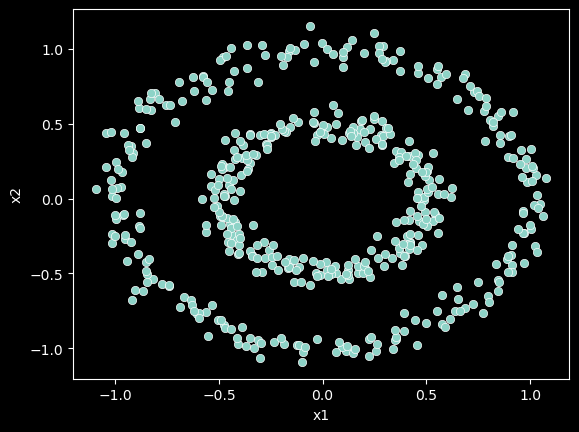

In [112]:
X = datasets['noisy_circles']
print(X.head())
sns.scatterplot(data=X, x='x1', y='x2');

<!-- #### Clustering -->

DBSCAN is implemented in the `DBSCAN` class from the `sklearn.cluster` module.

The constructor of the `DBSCAN` class takes the two parameters $\epsilon$ and $m$ as input.

Similar to `KMeans`, the `DBSCAN` class has a `fit()` method that takes the data as input and runs the DBSCAN algorithm on it.

After we fit the model to the data, we can use the `.labels_` attribute to get the discovered labels of the clusters assigned to each data point.

In [113]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)
X['cluster'] = dbscan.labels_

<!-- #### After clustering -->

The code below plots the data again, but this time with the cluster labels.

         x1        x2  cluster
0 -0.469276  0.210118        0
1 -0.164164  0.986075        1
2 -0.471454  0.019974        0
3 -0.670347 -0.657977        2
4 -0.826468  0.594071        2


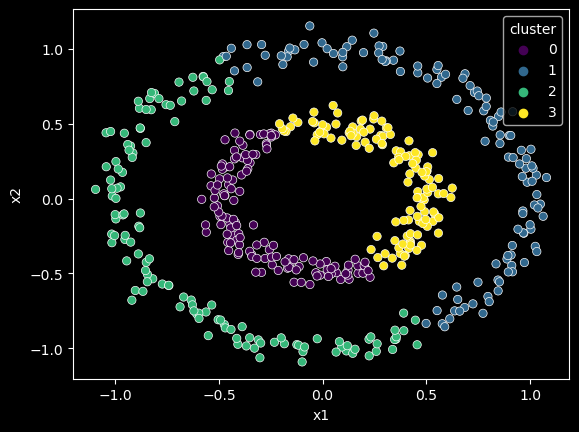

In [122]:
print(X.head())

sns.scatterplot(data=X, x='x1', y='x2', hue='cluster', palette='viridis');

Just because DBSCAN does better than k-means on the circles dataset, it does not mean that DBSCAN is always better than k-means. Each clustering algorithm has its own strengths and weaknesses.

#### Implementation

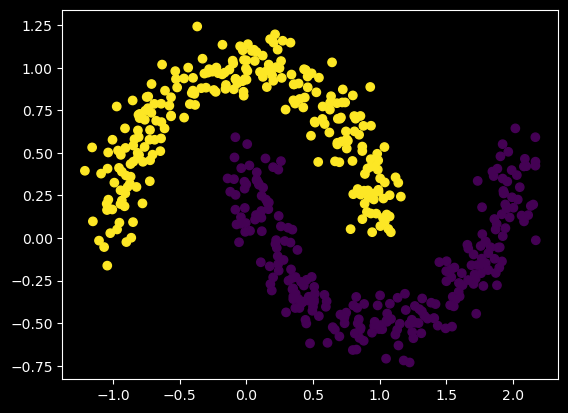

In [ ]:
import pandas as pd

def euclidean_distance(row1, row2):
    """Compute Euclidean distance between two points."""
    return ((row1 - row2) ** 2).sum() ** 0.5

def get_neighbors(df, point_idx, eps):
    """Find neighbors within `eps` distance of a point."""

    point = df.iloc[point_idx]
    neighbors = df.apply(lambda row: euclidean_distance(point, row), axis=1)
    return list(neighbors[neighbors <= eps].index)

def expand_cluster(df, labels, point_idx, neighbors, cluster_id, eps, min_samples):
    """Expand a cluster starting from a core point."""

    # Assign the point to the cluster
    labels[point_idx] = cluster_id  
    
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]
        
        # If the point is noise, make it a part of the cluster
        if labels[neighbor_idx] == -1:  
            labels[neighbor_idx] = cluster_id
            
        # If the point is unvisited, mark it as visited and add its neighbors to the list
        elif labels[neighbor_idx] == 0:  
            labels[neighbor_idx] = cluster_id
            new_neighbors = get_neighbors(df, neighbor_idx, eps)
            
            # If the point is a core point, merge its neighbors
            if len(new_neighbors) >= min_samples:
                neighbors = neighbors + [n for n in new_neighbors if n not in neighbors]
                
        i += 1

def dbscan(df, eps, min_samples):
    """DBSCAN clustering algorithm."""
    # 0 means unvisited; -1 means noise; other numbers indicate the cluster ID
    labels = [0] * len(df)  
    cluster_id = 0
    
    for point_idx in range(len(df)):
        # Skip if the point is already visited
        if labels[point_idx] != 0:  
            continue
        
        neighbors = get_neighbors(df, point_idx, eps)
        
        # Mark as noise if not enough neighbors
        if len(neighbors) < min_samples:  
            labels[point_idx] = -1
        else:
            # Start a new cluster
            cluster_id += 1  
            expand_cluster(df, labels, point_idx, neighbors, cluster_id, eps, min_samples)
            
    return labels

X = datasets['noisy_moons']
labels = dbscan(X[['x1', 'x2']], eps=0.2, min_samples=5)
X['cluster'] = labels

plt.scatter(X['x1'], X['x2'], c=X['cluster'], cmap='viridis');

### Comparing DBSCAN and K-means

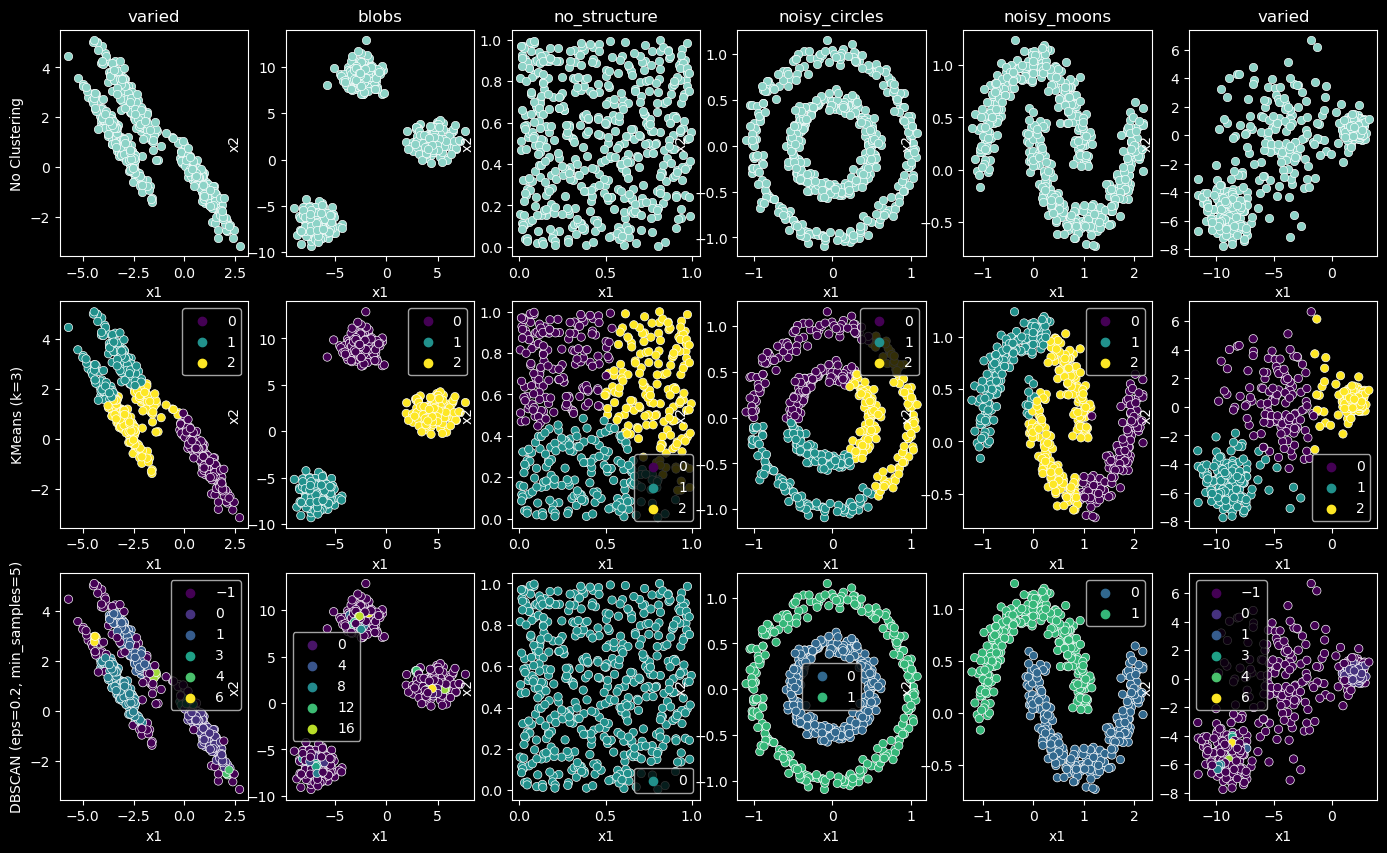

In [ ]:
fnames = ["aniso", "blobs", "no_structure", "noisy_circles", "noisy_moons", "varied"]

datasets = {}

fig, axs = plt.subplots(3, len(fnames), figsize=(17, 10))

for i, fname in enumerate(fnames):
    df = pd.read_csv(url + fname + ".csv", index_col=0)
    df.columns = ['x1', 'x2']
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(df)
    kmeans_labels = kmeans.labels_
    dbscan = DBSCAN(eps=0.2, min_samples=5)
    dbscan.fit(df)
    dbscan_labels = dbscan.labels_
    
    ax = sns.scatterplot(data=df, x='x1', y='x2', ax=axs[0][i]);
    ax.set(title=fname)
    ax = sns.scatterplot(data=df, x='x1', y='x2', hue=kmeans_labels, ax=axs[1][i],  palette='viridis');
    ax = sns.scatterplot(data=df, x='x1', y='x2', hue=dbscan_labels, ax=axs[2][i],  palette='viridis');

    axs[0][0].set(title=fname, ylabel='No Clustering')
    axs[1][0].set(ylabel='KMeans (k=3)')
    axs[2][0].set(ylabel='DBSCAN (eps=0.2, min_samples=5)')

Note that the two algorithms work better on different datasets.

Furthermore, the parameters of the two algorithms ($k$ for nearest neighbor and $\epsilon$ and $m$ for DBSCAN) need to be tuned to get the best results for an individual datasets. 

## Challenges 

### Limitations of Clustering

Note that not all data sets are suitable for clustering. Some data sets do not have a well-defined cluster structure. 

For example, below we try the k-means algorithm on the sentiments dataset. We know that the data set has three classes: positive, negative, and neutral. However, the k-means algorithm fails to discover the three classes. This is because the data set does not have a well-defined cluster structure.

In [ ]:
import pandas as pd
data = pd.read_csv('https://raw.githubusercontent.com/fahadsultan/datascience_ml/main/data/chat_dataset.csv')
data.head()

,message,sentiment
0,I really enjoyed the movie,positive
1,The food was terrible,negative
2,I'm not sure how I feel about this,neutral
3,The service was excellent,positive
4,I had a bad experience,negative


In [ ]:
vocab = ' '.join(data['message'].values).lower().split()
vocab = list(set(vocab))

bow = pd.DataFrame(0, columns=vocab, index=data.index)
for word in vocab:
    bow[word] = data['message'].apply(lambda x: x.lower().split().count(word))

kmeans = KMeans(n_clusters=3, random_state=0)

def l2_norm(x):
    return (sum(x**2))**(1/2)

bow = bow.apply(lambda x: x/l2_norm(x), axis=1)
kmeans.fit(bow)

data['label'] = kmeans.labels_

In [ ]:
data['label'].value_counts()

1    201
2    199
0    184
Name: label, dtype: int64

In [ ]:
data.groupby(['label', 'sentiment']).size()

label  sentiment
0      negative      50
       neutral       72
       positive      62
1      negative      69
       neutral       70
       positive      62
2      negative      28
       neutral      117
       positive      54
dtype: int64

### Relationship between Clusters and Labels

Please take caution in comparing the discovered clusters with any available labels for a dataset. 

In clustering, the label 'values' are arbitrary. For example, if we have a dataset with three classes, we can label them as 0, 1, and 2 or as 1, 2, and 3 or as 100, 200, and 300.

In [ ]:
from sklearn.datasets import load_iris

data = load_iris(as_frame=True)
X    = data['data']

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
cluster_labels = kmeans.labels_

y    = data['target']

sum(cluster_labels == y)/len(y)

0.24

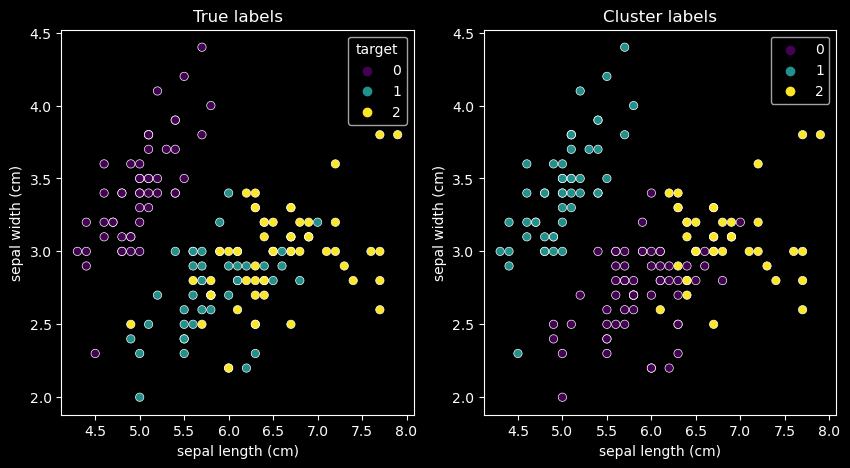

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = sns.scatterplot(data=X, \
                x='sepal length (cm)', \
                y='sepal width (cm)', \
                hue=y, \
                palette='viridis', ax=axs[0]);
ax.set(title="True labels");

ax = sns.scatterplot(data=X, \
                x='sepal length (cm)', \
                y='sepal width (cm)', \
                hue=cluster_labels, \
                palette='viridis', ax=axs[1]);
ax.set(title="Cluster labels");

### Silhouette Score

The Silhouette Score is calculated using the **mean intra-cluster distance ($a$)** and the **mean nearest-cluster distance ($b$)** for each sample. The Silhouette Coefficient for a sample is 

$$\text{Silhouette Coefficient} = \frac{(b - a)}{\text{max}(a, b)}$$

where $b$ is the distance between a sample and the nearest cluster that the sample is not a part of. 

Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.

`sklearn.metrics.silhouette_score` function returns the mean Silhouette Coefficient over all samples. To obtain the values for each sample, use `silhouette_samples`.

**The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters**. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

A score of 1 indicates that the object is far away from the neighboring clusters. A score of 0 indicates that the object is close to the decision boundary between two neighboring clusters. A score of -1 indicates that the object may have been assigned to the wrong cluster.

#### Silhouette Score to identify $k$, $\epsilon$ and `min_samples`

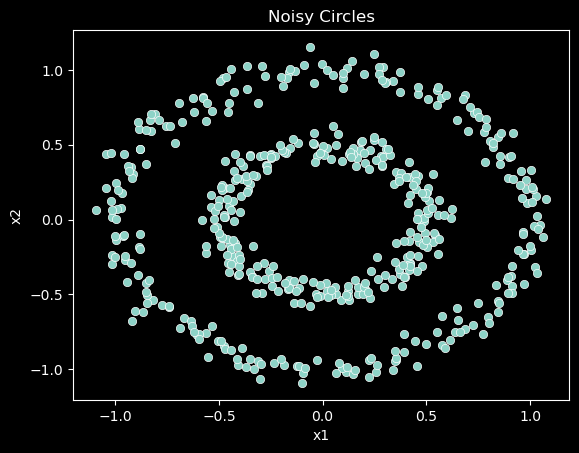

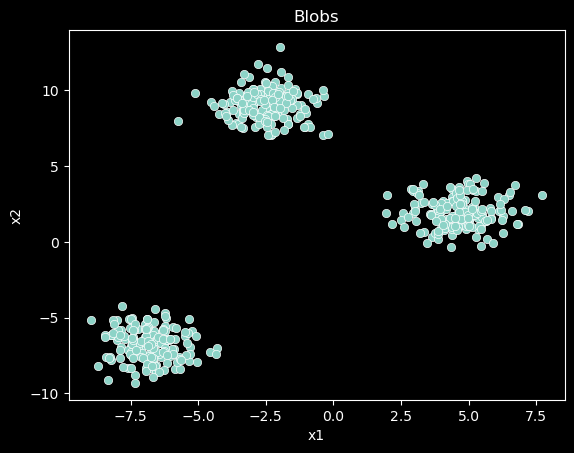

In [ ]:
X = datasets['noisy_circles']
ax = sns.scatterplot(data=X, x='x1', y='x2');
ax.set(title="Noisy Circles");

plt.figure();
X = datasets['blobs']
ax = sns.scatterplot(data=X, x='x1', y='x2');
ax.set(title="Blobs");

#### Plotting Silhouette score to find `k` 

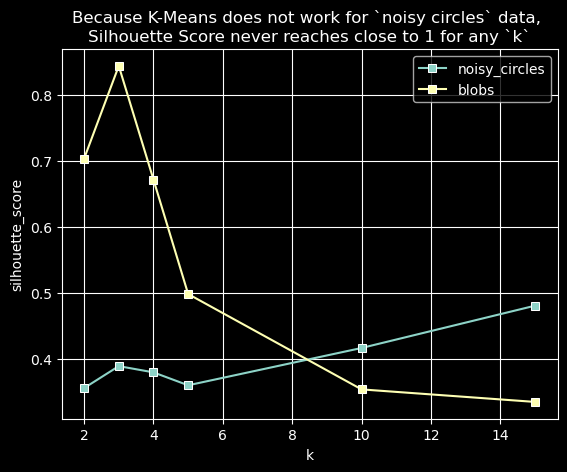

In [ ]:
from sklearn.metrics import silhouette_score

sscores = {'noisy_circles':[], 'blobs':[]}
ks = [2, 3, 4, 5, 10, 15]
url = "https://raw.githubusercontent.com/fahadsultan/datascience_ml/main/data/clusters/"

for name in ['noisy_circles', 'blobs']:

    X = pd.read_csv(url + name + ".csv", index_col=0)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        sscores[name].append(score)

ax = sns.lineplot(x=ks, y=sscores['noisy_circles'], marker='s');
ax = sns.lineplot(x=ks, y=sscores['blobs'], marker='s');
ax.set(xlabel='k', ylabel='silhouette_score');

plt.grid()
plt.legend(['noisy_circles', 'blobs']);
plt.title('Because K-Means does not work for `noisy circles` data, \nSilhouette Score never reaches close to 1 for any `k`');

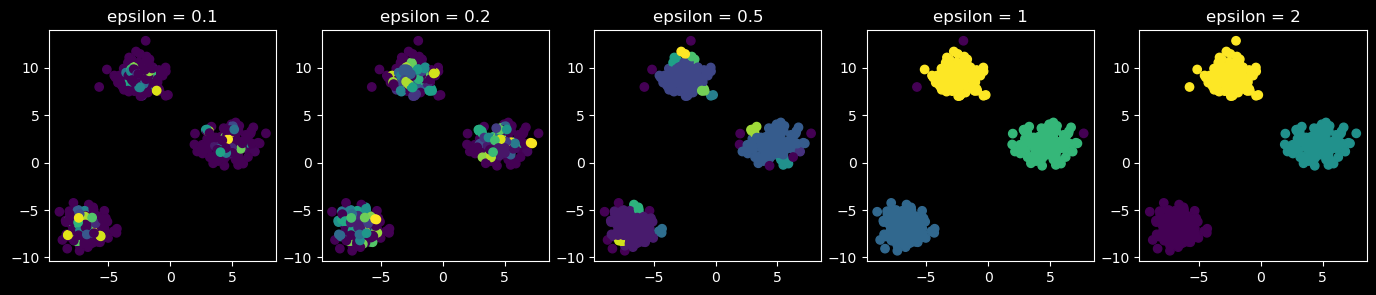

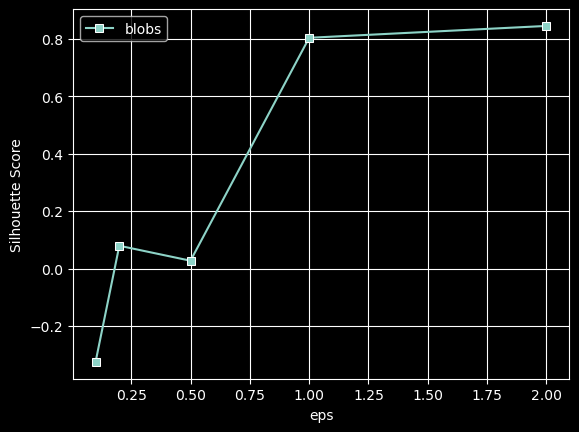

In [120]:
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


epsilons = [0.1, 0.2, 0.5, 1, 2]

fig, axs = plt.subplots(1, len(epsilons), figsize=(17, 3))


X = datasets['blobs']
sscores = []
for i, e in enumerate(epsilons):
    dbscan = DBSCAN(eps=e, min_samples=2)
    dbscan.fit(X[['x1', 'x2']])
    score = silhouette_score(X, dbscan.labels_)
    sscores.append(score)
    # sns.scatterplot(data=X, x='x1', y='x2', hue=dbscan.labels_)
    axs[i].scatter(X['x1'], X['x2'], c=dbscan.labels_)
    axs[i].set_title("epsilon = "+ str(e))

plt.figure();
ax = sns.lineplot(x=epsilons, y=sscores, marker='s');
ax.set(xlabel='eps', ylabel='Silhouette Score');

plt.grid()
plt.legend(['blobs']);